# Introduction
In this notebook I will discuss explore how to include chemical stressors in models of bacterial communtiiers. 

# Model

we start with the basic formulation of the MiCRM describing the dynamics of $N$ bacterial consumer populations and $M$ resources:

\begin{align}
    \frac{dC_i}{dt} &=  \sum_{\alpha}^M \bigg[ C_i R_{\alpha} u_{i \alpha} (1 - l_{\alpha}) \bigg] - C_i m_i \\
    \frac{dR_{\alpha}}{dt} &= \rho_{\alpha} - R_{\alpha} \omega_{\alpha} - \sum_{i}^N C_i R_{\alpha} u_{i \alpha} + \sum_{i}^N \sum_{\beta}^M C_i R_{\beta} u_{i \beta} l_{\beta \alpha}
\end{align}

# Chemical stressors

To think about how we include chemical stressors we can consider the effects of stressors on consumers and consumers on stressors independently. To make the difference between stressors and "normal" resources we introduce the $R^+$ and $R^-$ notation which indicate that a given substrate is dictated by the dynamics described above or the stressor effects we discuss below.  

## Stressors $\to$ Consumers
From the system of equations above there are two ways in which stressors could affect consumer populations:
1. As a direct mortality based on the abundance of the stressor in the environment.
2. By affecting resource uptake of other substrates in the enviroment. 

### 1) Direct mortality
Direct mortality $m_{i, R^-_{\alpha}}$ is the simplest way to model the effects taking the general form:
$$
    m_{i, R^-_{\alpha}} = f(C_i, R^-_{\alpha}, u_{i,\alpha}, \theta_{i,\alpha})
$$

The simplest form is to use a linear functional response as with the resources in the original MiCRM model:

$$
   m_{i, R^-_{\alpha}} = C_i R^-_{\alpha} u_{i,\alpha} \theta_{i,\alpha}
$$

where the additional $\theta_{i,\alpha}$ parameter describes the "toxicity" of the stressor. In general one could also think of $\theta_{i,\alpha}$ as a conversion parameter, set to 1 for resources and negative values for stressors

One could also use other functional forms such as a michelis-menten type functional response:

$$
   m_{i, R^-_{\alpha}} = C_i u_{i,\alpha} \theta_{i,\alpha} \frac{R^-_{\alpha}}{R^-_{\alpha} + k_{i,\alpha}}
$$

where again $\theta_{i,\alpha}$ gives the toxicity of the resource which saturates as a function of its environmental abundance with a saturation constant $k_{i,\alpha}$. 


### 2)Resource uptake
The effects of enviromental stressors could also be included via the uptake terms as the uptake of other substrates is inhibited by the presence of a stressor. In this case we express the uptake matrix $u$ in terms of the stressor abundance so that:

$$
    u_{i\beta} = u_{i,\beta,0} \ f_{i \beta}(R_{\alpha}^-) 
$$

where $u_{i,\beta,0}$ is the original uptake rate in the absence of the stressor and $f(R_{\alpha}^-)$ is a function ranging between $0-1$ which scales resource uptake. The natural choice here would again be some michealis-menten kinetics...

## Consumers + Environment $\to$ Stressors 
We also need to consider the dynamics of the stressors. this consists of two main parts:
1. The "intrinsic" dynamics not linked to the biomasses of consumers
2. The dynamics linked to consumer biomass via the uptake and leakage? of resources. 

## 1) Intrinsic Dynamics
These effects effectively boil down to the rate at which stressors are supplied and removed from the system. The simplest choice is to use simple chemostat type model where the supply $g(R_{\alpha}^-)$ is:
$$
    g(R_{\alpha}^-) = \rho_{\alpha} - \omega_{\alpha} R_{\alpha}^-
$$

where $\rho_{\alpha}$ is the supply rate and $\omega_{\alpha} $ is the dillution rate. Can also consider a pulse type supply term 
$$
    g(R_{\alpha}^-) = \rho_{\alpha}(t) - \omega_{\alpha} R_{\alpha}^- \quad \text{where} \quad \rho_{\alpha}(t) = \cases{x \quad \text{when} \quad t = \tau \\
       0 \quad \text{when} \quad t \neq \tau}
$$

which supplies the stressor with a pulse value of $x$ at time point $\tau$. Note that a single pulse at the begining of the experiment with no dillution (i.e. $\tau = 0, \omega = 0$) is the setup used in Tom Smith's experiments. 

## 2) Consumer dynamics
We also need to consider how consumers affect the stressor dynamics. In general this will occur the same way in which resources are normally consumed, the main question being whether consumers benifit, loose out or react neutraly to this. The effects of consumers on stressors are thus the same as the effects on the resource substrates:
$$
    \sum_{i}^N C_i R_{\alpha}^- u_{i \alpha}
$$

We could also model the production of stressors (e.g. chemical warfare)by consumers though this is beyond the scope of this work for now. 

## First Steps

Taking these many mechanisms together there are clearly many options for modeling the effects of stressors. Overall the simplest model to consider is simply adding the direct mortality terms by introducing the $\theta_{i \alpha}$ parameter that determines the effects of resources on consumer growth. This gives the consumer growth equation:

\begin{align}
    \frac{dC_i}{dt} &=  \sum_{\alpha}^M \bigg[ C_i R_{\alpha} u_{i \alpha} \theta_{i \alpha} (1 - l_{\alpha}) \bigg] - C_i m_i \\
    \frac{dR_{\alpha}}{dt} &= \rho_{\alpha} - R_{\alpha} \omega_{\alpha} - \sum_{i}^N C_i R_{\alpha} u_{i \alpha} + \sum_{i}^N \sum_{\beta}^M C_i R_{\beta} u_{i \beta} l_{\beta \alpha}
\end{align}

This ends up being quite simple. We can set $\theta = 1$ for normal resources and $\theta = -1$ for stressors. The substrate dynamics (including resources and stressors) remain the same with consumer uptake being linked explicty to its removal from the resource pool. The major difference is thus that uptake of stressors reduces biomass, not increases it. 

In changing the structure we also introduce a carbon loss term as biomass removed by the uptake of the stressors (when $\theta < 0$). We could leave this as a sink in the model, which would be equivilant to the resources being washed out instantaneously and made unavalible to all the consumer species.

In [192]:
using Pkg
Pkg.activate("..")

using MiCRM, Plots, Random, LinearAlgebra

  Activating environment at `~/Projects/Working/ErCite/chemicalstressors/Project.toml`


In [55]:
Random.seed!(1)

N,M = 3,3
params = MiCRM.random_micrm_stressor_params(N,M,0.3)
θ_indx = findall(params[:θ])
#norm uptake
[params[:u][i,:] .= params[:u][i,:] ./ sum(params[:u][i,:]) for i = 1:N]
#set stressor inflow
params[:ρ][θ_indx] .= 1.0
#set stressor leakage
params[:l][:,θ_indx] .= 0.0

@named sys_stress = MiCRM.micrm_stressor_system(params);


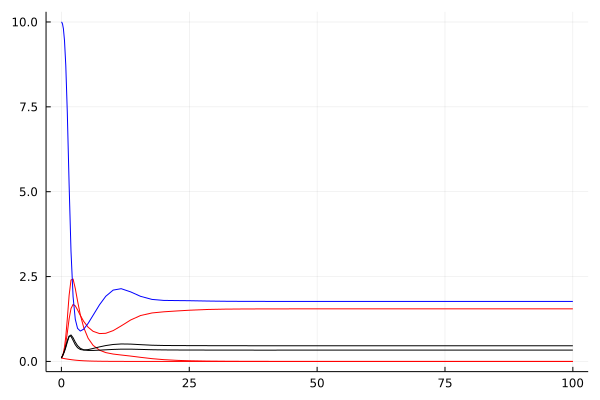

In [56]:
#convert to problem
#define starting mass
u0 = fill(0.1, N + M)
u0[N .+ θ_indx] .= 10.0
u0 = [states(sys_stress)[i] => u0[i] for i = eachindex(u0)]
tspan = (0.0, 100.0) #define tspan
prob = ODEProblem(sys_stress,u0,tspan,[])

# pulse_t = 500.0 
# condition(u,t,integrator) = t == pulse_t
# affect!(integrator) = integrator.u[(N+1):end] .+= 600
# cb = DiscreteCallback(condition,affect!)

sol_stress = solve(prob)

x = max.(0,(sol_stress[:,:]))'
col_vec = fill(:red, 1, N+M)
col_vec[N+1 : end] .= :black
col_vec[findall(params[:θ]) .+ N] .= :blue
p1 = plot(sol_stress.t,x, legend = false, color = col_vec)

# t_vec = pulse_t:0.01:(pulse_t + 1)
# x = max.(0,hcat(sol_stress.(t_vec)...)')
# col_vec = fill(:red, 1, N+M)
# col_vec[N+1 : end] .= :black

# p2 = plot(t_vec, log10.(x), legend = false, color = col_vec )

# p3 = scatter(sol_stress(pulse_t)[1:N],sol_stress(tspan[end])[1:N])
# Plots.abline!(p3, 1, 0)
# plot(p1,p2,p3, layout = (1,3), size = (800,300))

Do Stressor Pulses disrupt certain types of communities more?
 - Competition vs Cooperation
 - Hierarchical vs random


In [586]:
#square with sign
sq_sgn(x) = sign(x) * x^2

#calculate euclidian distance
function euclid_dist(a,b)
    sum(sq_sgn, a .- b)
end

function cosine_dist(a,b)
    sum(a .* b) / sqrt(sum(abs2,a)*sum(abs2,b))
end

cosine_dist (generic function with 1 method)

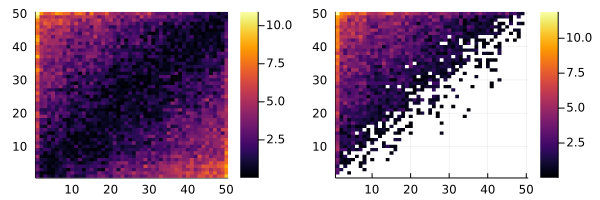

In [596]:
N,M = 50,50
D = 100 #Dimensionality

θC = [rand(D) for i = 1:N]
θR = [rand(D) for i = 1:M]

indx_C = sortperm(norm.(θC,1))
indx_R = sortperm(norm.(θR,1))

#calculate consumer resource distance matrix
d_mat_cr = [abs.(euclid_dist(x,y)) for x = θC, y = θR][indx_C,indx_R]
#caluclate leakage matrix
d_mat_rr = [euclid_dist(x,y) <= 0 ? Inf : euclid_dist(x,y)  for x = θR, y = θR][indx_R,indx_R]

p1 = heatmap(d_mat_cr)
p2 = heatmap(d_mat_rr)

plot(p1,p2, size = (600,200))

In [470]:
d_mat_rr

50×50 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

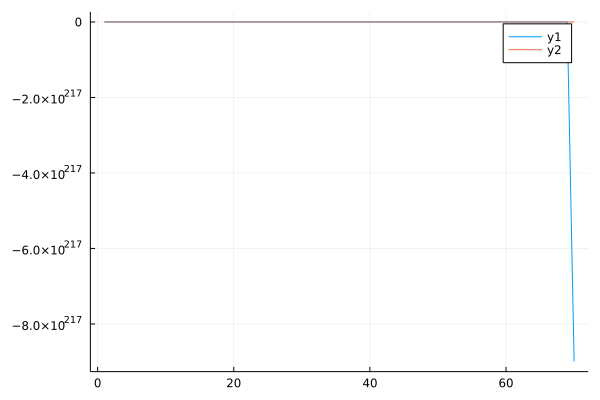

In [585]:
function Δx(dx,x,p)
    [
     x[1] * (p[1] * x[2]  + p[2] * x[1]),
     p[3] * x[1] 
    ]
end

x = [1.0,1.0]
dx = similar(x)
p = [0.1,-0.1,0.1]

Nt = 70

res = zeros(2,Nt)
for i = 1:Nt
    res[:,i] .= x 
    dx = Δx(dx,x,p)
    x = x .+ dx
    # println(dx)
end


plot(res')

In [539]:
dx = similar(x)

2-element Vector{Float64}:
 2.382958182e-314
 2.386320888e-314

In [540]:
Δx(dx,x,p)

0.013478489153329056

In [541]:
dx

2-element Vector{Float64}:
 0.060363267476447525
 0.013478489153329056